In [207]:
import sys
import gzip
import random
import collections
import math
import datetime
from datetime import *

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import plotly.express as px
import pylab
import scipy.stats as stats
import plotly.graph_objects as go

from scipy.stats import bootstrap, ttest_ind, ttest_rel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
from sklearn.metrics import silhouette_samples, silhouette_score


In [208]:
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None  # default='warn'

# Dataset of the beers (beers.csv)

In [209]:
#load the data beers.csv
df_beers = pd.read_csv('./data/beers.csv')

In [210]:
df_beers.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [211]:
#We do not use some features
list_considered_variable=['beer_id','beer_name','brewery_id','brewery_name','style',
                          'nbr_reviews','nbr_ratings','avg', 'abv']
df_beers=df_beers[list_considered_variable]

In [212]:
#Each style gets map to one of the 15 category
beer_catalog = {
    'Bocks' : ['Bock', 'Doppelbock', 'Eisbock', 'Maibock', 'Weizenbock', 'Maibock / Helles Bock'],

    'Dark Ales' : ['Dubbel', 'Roggenbier', 'Scottish Ale', 'Winter Warmer'],

    'Hybrid Beers' : ['Bière de Champagne / Bière Brut', 'Braggot', 'California Common / Steam Beer', 'Cream Ale'],

    'Pale Ales' : ['American Amber / Red Ale', 'American Blonde Ale', 'American Pale Ale', 'Belgian Blonde Ale',
    'Belgian Pale Ale', 'Bière de Garde', 'English Bitter', 'English Pale Ale', 'English Pale Mild Ale', 'Extra Special / Strong Bitter (ESB)',
    'Grisette', 'Irish Red Ale', 'Kölsch', 'Saison', 'Saison / Farmhouse Ale', 'Belgian Strong Pale Ale', 'American Pale Ale (APA)'],

    'Porters' : ['American Porter', 'Baltic Porter', 'English Porter', 'Imperial Porter', 'Robust Porter ', 'Smoked Porter'],

    'Stouts' : ['American Imperial Stout', 'American Stout', 'English Stout', 'Foreign / Export Stout', 'Irish Dry Stout', 'Oatmeal Stout',
    'Russian Imperial Stout', 'Milk / Sweet Stout', 'American Double / Imperial Stout'],

    'Wheat Beers' : ['American Dark Wheat Beer', 'American Pale Wheat Beer', 'Dunkelweizen', 'Grodziskie', 'Hefeweizen', 'Kristallweizen', 'Witbier', 
    'American Pale Wheat Ale', 'American Dark Wheat Ale', 'Berliner Weissbier', 'Kristalweizen'],

    'Brown Ales' : ['Altbier', 'American Brown Ale', 'Belgian Dark Ale', 'English Brown Ale', 'English Dark Mild Ale', 'Belgian Strong Dark Ale'],

    'Dark Lagers' : ['American Amber / Red Lager', 'Czech Amber Lager', 'Czech Dark Lager', 'European Dark Lager', 'Märzen',
    'Munich Dunkel', 'Rauchbier', 'Schwarzbier', 'Vienna Lager', 'Munich Dunkel Lager', 'Euro Dark Lager'],

    'India Pale Ales' : ['American IPA', 'American Double / Imperial IPA', 'Belgian IPA', 'Black IPA', 'Brut IPA', 'English IPA', 'English India Pale Ale (IPA)', 
    'Imperial IPA', 'Milkshake IPA', 'New England IPA', 'American Black Ale'],

    'Pale Lagers' : ['American Adjunct Lager', 'American Lager', 'Bohemian / Czech Pilsner', 'Czech Pale Lager', 'European / Dortmunder Export Lager',
    'European Pale Lager', 'European Strong Lager', 'Festbier / Wiesnbier', 'German Pilsner', 'Helles', 'Imperial Pilsner', 'India Pale Lager (IPL)',
    'Kellerbier / Zwickelbier', 'Light Lager', 'Malt Liquor', 'Czech Pilsener', 'Euro Pale Lager', 'American Pale Lager', 'German Pilsener', 'Dortmunder / Export Lager', 
    'Euro Strong Lager', 'Munich Helles Lager', 'American Double / Imperial Pilsner', 'American Malt Liquor', 'Märzen / Oktoberfest'],

    'Specialty Beer' : ['Chile Beer', 'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale', 'Happoshu', 'Herb and Spice Beer', 'Japanese Rice Lager',
    'Kvass', 'Low-Alcohol Beer', 'Pumpkin Beer', 'Rye Beer', 'Sahti', 'Smoked Beer', 'Herbed / Spiced Beer', 'Pumpkin Ale', 'Scottish Gruit / Ancient Herbed Ale', 'Low Alcohol Beer'],

    'Strong Ales' : ['American Barleywine', 'American Strong Ale', 'Belgian Dark Strong Ale', 'Belgian Pale Strong Ale', 'English Barleywine', 'English Strong Ale',
    'Imperial Red Ale', 'Old Ale', 'Quadrupel (Quad)', 'Scotch Ale / Wee Heavy', 'Tripel', 'Wheatwine', 'Fruit / Vegetable Beer'],
    
    'Wild/Sour Beers' : ['Berliner Weisse', 'Brett Beer', 'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale', 'Fruit Lambic',
    'Fruited Kettle Sour', 'Gose', 'Gueuze', 'Lambic', 'Wild Ale', 'Lambic - Unblended', 'Lambic - Fruit', 'American Wild Ale'],

    'Weird Cocktail' : ['Black & Tan']
}

In [213]:
beer_catalog_reverse = {}
for key, values in beer_catalog.items():
    for value in values:
            beer_catalog_reverse.setdefault(value, []).append(key)

In [214]:
def category_check(beer_style, beer_catalog):
    '''
    Return the new columns of 15 categories taken from the website https://www.beeradvocate.com/beer/styles/
    '''
    for category_name, beer_styles in beer_catalog.items():
        if beer_style in beer_styles:
            return category_name

In [215]:
df_beers['category'] = df_beers['style'].apply(lambda beer_style: category_check(beer_style, beer_catalog))

In [216]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_reviews,nbr_ratings,avg,abv,category
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.7,Pale Lagers
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,3.8,Pale Lagers
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.8,Pale Lagers
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.0,Pale Lagers
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.5,Pale Lagers


# Dataset of the users (users.csv) and filtering

In [217]:
#load the data

df_users = pd.read_csv('./data/users.csv')
print(df_users.describe())
df_users.head(5)

         nbr_ratings    nbr_reviews        joined
count  153704.000000  153704.000000  1.510520e+05
mean       54.605163      16.847876  1.357238e+09
std       252.388790     139.846706  9.195131e+07
min         1.000000       0.000000  8.407944e+08
25%         1.000000       0.000000  1.303121e+09
50%         3.000000       0.000000  1.391944e+09
75%        16.000000       2.000000  1.417691e+09
max     12046.000000    8970.000000  1.501495e+09


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


In [218]:
# First user filtering phase 

# keep users from the USA only & who have made a minimum number of reviews in order to participate in our study

df_us_users = df_users[df_users.location.str.contains('United States', na=False)]
nb_us_users = df_us_users['user_id'].nunique()
print(f"There are {nb_us_users} US users")

#choose a minimum number of ratings per user, since we want to analyse an evolution!
cutoff_low = 500
print("Cutoff low : ", cutoff_low)

#choose a maximum number of ratings per user, we want to filter our "super-users" or organisations
cutoff_high = df_us_users.nbr_ratings.quantile(0.99)
print("Cutoff high : ", cutoff_high)

#create a valid user dataframe and a set with the valid user_names
df_us_users = df_us_users[(df_us_users.nbr_ratings < cutoff_high) &
                                (df_us_users.nbr_ratings >= cutoff_low)]
us_users_names = set(df_us_users.user_name)
print("Number of users left : ", len(us_users_names))
print("Total of ratings left : ", df_us_users.nbr_ratings.sum())

#convert the 'joined' column into datetime format
df_us_users.loc[:,'date_joined'] = pd.to_datetime(df_us_users['joined'].apply(lambda dt : datetime.fromtimestamp(dt).strftime('%Y-%m-%d')))

There are 113223 US users
Cutoff low :  500
Cutoff high :  1135.0
Number of users left :  2232
Total of ratings left :  1652164


# Dataset of the ratings (ratings.txt.gz) and filtering

In [219]:
# We now gather some more user information by analyzing their behaviour as a reviewer

In [220]:
def parse(filename):
    """
    Parse a txt.gz file and return a generator for it
    Copyright © 2017 Gael Lederrey <gael.lederrey@epfl.ch>
    :param filename: name of the file
    :return: Generator to go through the file
    """
    file = gzip.open(filename, 'rb')
    entry = {}
    # Go through all the lines
    for line in file:
        # Transform the string-bytes into a string
        line = line.decode("utf-8").strip()

        # We check for a colon in each line
        colon_pos = line.find(":")
        if colon_pos == -1:
            # if no, we yield the entry
            yield entry
            entry = {}
            continue
        # otherwise, we add the key-value pair to the entry
        key = line[:colon_pos]
        value = line[colon_pos + 2:]
        entry[key] = value

In [221]:
gen = parse('./data/ratings.txt.gz')

In [222]:
#We create the dataframe of the valid us users previously determined

create = False

#This takes a few minutes (if create = True)
if create:
    undesired_features = set(['text','review', 'brewery_name', 'brewery_id', 'user_id', 'beer_name'])
    full_ratings_ls = []
    int_cols = ['beer_id']
    float_cols = ['abv','appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

    review = next(gen)
    cols = [key for key, _ in review.items() if key not in undesired_features]

    for idx, review in enumerate(gen):
        user_name = review['user_name']
        valid_rows = [value for key, value in review.items() if key not in undesired_features]
        #only keep ratings of the previously filtered users
        if user_name in us_users_names:
            full_ratings_ls.append(valid_rows)

    df_ratings = pd.DataFrame(full_ratings_ls, columns = cols)

    df_ratings[int_cols] = df_ratings[int_cols].astype('int')
    df_ratings[float_cols] = df_ratings[float_cols].astype('float') 
    df_ratings["date"] = pd.to_datetime(df_ratings.date.apply(
        lambda date : datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d')
    ))

    #There is only one review in the year 2000, wich is an outlier
    start_date = pd.to_datetime("2001-01-01")
    df_ratings = df_ratings.loc[df_ratings['date'] >= start_date]   
    df_ratings.to_pickle('./data/ratings_valid_user.pkl')

else:
    df_ratings = pd.read_pickle('./data/ratings_valid_user.pkl')

In [223]:
#add the category of the beer
beers_id_cat = df_beers[['beer_id', 'category']]
df_ratings = pd.merge(df_ratings, beers_id_cat, on = 'beer_id')

#add the rating number, starts at 0
df_ratings.sort_values(by = "date", inplace=True)
df_ratings["rating_number"] = df_ratings.groupby("user_name").transform("cumcount")

#we also convert the date to the proper format
df_ratings["date"] = pd.to_datetime(df_ratings["date"])

In [224]:
#We apply the second of our filters, we only keep the 500 first ratings. (rating number at which you are considered an expert)
nb_ratings_expert = 500
df_us_ratings = df_ratings[df_ratings["rating_number"] < nb_ratings_expert]

In [225]:
df_us_ratings.head(5)

,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating,category,rating_number
1640018,167,Witbier,NaN,2001-03-16,frank4sail,4.5,4.5,4.0,5.0,5.0,4.75,Wheat Beers,0
311428,3558,Czech Pilsener,5.00,2001-06-18,Mark,4.0,4.0,3.0,4.0,4.0,3.90,Pale Lagers,0
17313,73,Milk / Sweet Stout,5.20,2001-06-18,Mark,5.0,5.0,5.0,5.0,5.0,5.00,Stouts,1
136697,261,Vienna Lager,4.48,2001-06-24,Mark,4.0,3.0,3.0,3.0,3.0,3.06,Dark Lagers,2
442671,87,American Pale Ale (APA),5.40,2001-06-24,Mark,4.0,4.0,1.0,3.0,3.0,3.10,Pale Ales,3


In [226]:
#We go back to users and compute on how many different days they were active

user_active = df_us_ratings.groupby(['user_name'], as_index = False).date.nunique()
user_active.columns = ['user_name', 'active_days']
df_us_users = df_us_users.merge(user_active, on = 'user_name')

In [227]:
# We compute how long it took them to submit the 500 ratings
user_delta = df_us_ratings.groupby('user_name', as_index = False).apply(lambda usr: (usr.date.max() - usr.date.min()).days)
user_delta.columns = ['user_name', 'delta_first_last']
df_us_users = df_us_users.merge(user_delta, on = 'user_name')
df_us_users.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date_joined,active_days,delta_first_last
0,1131,188,okcnittany.144868,OKCNittany,1.182766e+09,"United States, Oklahoma",2007-06-25,187,2397
1,732,14,byofb.537281,BYOFB,1.292065e+09,"United States, Wisconsin",2010-12-11,32,756
2,585,389,ferrari29.320392,ferrari29,1.239790e+09,"United States, Illinois",2009-04-15,202,1193
3,1078,10,colsanders123.545441,ColSanders123,1.293620e+09,"United States, Georgia",2010-12-29,135,1077
4,914,890,jays2629.517433,JayS2629,1.287828e+09,"United States, Alabama",2010-10-23,101,244


In [228]:
# We compute the maximum number of ratings the user has done in a single month

user_month = df_us_ratings[['user_name','date']].groupby(["user_name", pd.Grouper(freq = "M", key="date")], as_index = False).size()
user_month = user_month.groupby('user_name', as_index = False).apply(lambda usr : max(usr['size']))
user_month.columns = ['user_name', 'max_active_month']
df_us_users = df_us_users.merge(user_month, on = 'user_name') 

In [229]:
# We also want to know how much time the users took for submitting different number of ratings.

def compute_diff_date(user):
    """
    computes the difference in days between the 50th and the 1st ratings submitted by a user
    """
    diff = {}
    day = 50
    diff[str(day)] = (user[user["rating_number"] == day-1]["date"].item() -\
                         user[user["rating_number"] == 0]["date"].item()).days
    return pd.Series(diff)

def compute_diff_date_last(user):
    """
    computes the difference in days between the 500th and the 450th ratings submitted by a user
    """
    diff = {}
    day = 450
    diff[str(day)] = (user[user["rating_number"] == 500-1]["date"].item() -\
                         user[user["rating_number"] == day]["date"].item()).days
    return pd.Series(diff)

In [230]:
# We focus on the 10% first reviews
# We make the assumption that users are beginners for these ratings

user_deltas_0_50 = df_us_ratings.groupby('user_name', as_index = False).apply(compute_diff_date)
df_us_users = df_us_users.merge(user_deltas_0_50, on = 'user_name')

In [231]:
# We focus on the 10% last reviews
# We make the assumption that users are experts for these ratings

user_deltas_450_500 = df_us_ratings.groupby('user_name', as_index = False).apply(compute_diff_date_last)
df_us_users = df_us_users.merge(user_deltas_450_500, on = 'user_name')

In [232]:
df_us_users.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date_joined,active_days,delta_first_last,max_active_month,50,450
0,1131,188,okcnittany.144868,OKCNittany,1.182766e+09,"United States, Oklahoma",2007-06-25,187,2397,91,45,16
1,732,14,byofb.537281,BYOFB,1.292065e+09,"United States, Wisconsin",2010-12-11,32,756,273,447,146
2,585,389,ferrari29.320392,ferrari29,1.239790e+09,"United States, Illinois",2009-04-15,202,1193,42,64,335
3,1078,10,colsanders123.545441,ColSanders123,1.293620e+09,"United States, Georgia",2010-12-29,135,1077,247,254,159
4,914,890,jays2629.517433,JayS2629,1.287828e+09,"United States, Alabama",2010-10-23,101,244,103,21,15


In [233]:
# We now have a lot more information about the reviewing behaviour of our us users
# We proceed with some more filtering to get the final set of users on which we will conduct our study.

# Minimum number of active days required:
min_active_days = 100
df_valid_users = df_us_users[df_us_users['active_days'] >= min_active_days]

# How many days needed to submit their 500 ratings:
min_delta = 365
max_delta = 7*365
df_valid_users = df_valid_users[(df_valid_users['delta_first_last'] > min_delta) & (df_valid_users['delta_first_last'] < max_delta)]

# Maximum number of reviews in a single month:
max_per_month = 70
df_valid_users = df_valid_users[df_valid_users['max_active_month'] <= max_per_month]

In [234]:
# To make the people more similar at the beginning and the end of their ratings career, 
# we decide to apply a last filter on the users

In [235]:
df_valid_users.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date_joined,active_days,delta_first_last,max_active_month,50,450
2,585,389,ferrari29.320392,ferrari29,1.239790e+09,"United States, Illinois",2009-04-15,202,1193,42,64,335
5,676,676,dodo2step.110880,Dodo2step,1.165576e+09,"United States, Pennsylvania",2006-12-08,411,2153,28,45,442
7,653,651,kadonny.156863,Kadonny,1.188986e+09,"United States, Pennsylvania",2007-09-05,357,1800,22,249,263
8,748,748,biggred1.206640,biggred1,1.206616e+09,"United States, Indiana",2008-03-27,318,819,37,102,69
9,546,484,brownbeer.220672,brownbeer,1.211105e+09,"United States, Missouri",2008-05-18,143,1815,62,204,1302


In [236]:
df_check = df_valid_users['50'].to_frame()
df_check.sort_values(by = '50', inplace=True)
fig = px.line(df_check, x = range(df_check.shape[0]), y = '50',
    title="Number of days taken to rate the first 50 beers").update_layout(    
    xaxis_title="Users sorted from smallest to biggest",
    yaxis_title="Number of days"
)
fig.add_hline(500, line_color = 'red')
fig.show()

In [237]:
#we notice that about 5% of the users take much a longer time to perform their first 50 ratings, 
#We decided to remove them in order to smooth out the global behaviour of users.

max_time_to_rate = 500
df_valid_users = df_valid_users[(df_valid_users['50'] < max_time_to_rate)]

In [238]:
df_check = df_valid_users['450'].to_frame()
df_check.sort_values(by = '450', inplace=True)
fig = px.line(df_check, x = range(df_check.shape[0]), y = '450',
    title="Number of days taken to rate the last 50 beers").update_layout(    
    xaxis_title="Users sorted from smallest to biggest",
    yaxis_title="Number of days"
)
fig.add_hline(500, line_color = 'red')
fig.show()

In [239]:
# We notive again that 2% of the remaining users take too much time to perform their last ratings.
# We decided to recut at 500days as our final filtering step
max_time_to_rate = 500
df_valid_users = df_valid_users[(df_valid_users['450'] < max_time_to_rate)]

In [240]:
# We have the final data set of users and the data set of their ratings

valid_usernames = set(df_valid_users['user_name'])
df_valid_ratings = df_us_ratings[df_us_ratings['user_name'].isin(valid_usernames)]
print(f"There is {len(valid_usernames)} users left and {df_valid_ratings.shape[0]} ratings in total.")

There is 970 users left and 485000 ratings in total.


In [241]:
df_valid_users.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date_joined,active_days,delta_first_last,max_active_month,50,450
2,585,389,ferrari29.320392,ferrari29,1.239790e+09,"United States, Illinois",2009-04-15,202,1193,42,64,335
5,676,676,dodo2step.110880,Dodo2step,1.165576e+09,"United States, Pennsylvania",2006-12-08,411,2153,28,45,442
7,653,651,kadonny.156863,Kadonny,1.188986e+09,"United States, Pennsylvania",2007-09-05,357,1800,22,249,263
8,748,748,biggred1.206640,biggred1,1.206616e+09,"United States, Indiana",2008-03-27,318,819,37,102,69
10,614,614,whynot44.2033,whynot44,1.052129e+09,"United States, Missouri",2003-05-05,276,1452,57,24,316


In [242]:
df_valid_ratings.head(5)

,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating,category,rating_number
1640018,167,Witbier,NaN,2001-03-16,frank4sail,4.5,4.5,4.0,5.0,5.0,4.75,Wheat Beers,0
311428,3558,Czech Pilsener,5.00,2001-06-18,Mark,4.0,4.0,3.0,4.0,4.0,3.90,Pale Lagers,0
17313,73,Milk / Sweet Stout,5.20,2001-06-18,Mark,5.0,5.0,5.0,5.0,5.0,5.00,Stouts,1
136697,261,Vienna Lager,4.48,2001-06-24,Mark,4.0,3.0,3.0,3.0,3.0,3.06,Dark Lagers,2
442671,87,American Pale Ale (APA),5.40,2001-06-24,Mark,4.0,4.0,1.0,3.0,3.0,3.10,Pale Ales,3


# Clustering

In [243]:
# Clustering starts :
# We want to check if it is possible to extract meaningful clusters
# out of the 50 first ratings submitted by users

In [244]:
# To do that, we check how many beers of different categories 
# a user rated in his first 50 ratings

df_to_cluster = df_valid_ratings[df_valid_ratings["rating_number"] < 50]
user_to_cat_first = df_to_cluster.groupby(["user_name", "category"]).size()
user_to_cat_first = user_to_cat_first.unstack(level=-1, fill_value = 0)
user_to_cat_first

category,Bocks,Brown Ales,Dark Ales,Dark Lagers,Hybrid Beers,India Pale Ales,Pale Ales,Pale Lagers,Porters,Specialty Beer,Stouts,Strong Ales,Weird Cocktail,Wheat Beers,Wild/Sour Beers
user_name,,,,,,,,,,,,,,,
-Rick,0,2,0,2,0,29,7,2,2,2,3,1,0,0,0
1000lbgrizzly,0,5,0,1,0,4,9,7,2,8,6,4,0,3,1
1424IpA,0,0,1,0,0,21,3,1,1,1,12,4,0,1,5
2Xmd,0,2,1,1,0,25,5,1,1,2,9,1,0,2,0
2ellas,0,2,1,0,0,31,9,0,0,0,2,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zenithberwyn,1,1,0,3,0,3,7,10,3,0,14,5,0,3,0
zhanson88,1,5,3,1,0,6,6,2,3,1,12,7,0,3,0
zookerman182,1,3,0,0,0,22,6,0,2,0,9,5,0,1,1


In [245]:
#Here we perform a silouhette score analysis to select a good number of cluster.
X = user_to_cat_first.values
y = 0

range_n_clusters = range(2, 15 + 1)
silhouette_score_list=[]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit(X)
    cluster_labels = clusterer.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_score_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
fig=px.line(x=range_n_clusters,y=silhouette_score_list)
fig.update_layout(
    title="Silhouette score",
    xaxis_title="Number of clusters",
    yaxis_title="Silhouette score",
    legend_title="Silhouette score",)
fig.show()


For n_clusters = 2 The average silhouette_score is : 0.25413325775018325
For n_clusters = 3 The average silhouette_score is : 0.23938684221896325
For n_clusters = 4 The average silhouette_score is : 0.21464242754530322
For n_clusters = 5 The average silhouette_score is : 0.19260175262458518
For n_clusters = 6 The average silhouette_score is : 0.1943307339741516
For n_clusters = 7 The average silhouette_score is : 0.18504541213544645
For n_clusters = 8 The average silhouette_score is : 0.16589581799014308
For n_clusters = 9 The average silhouette_score is : 0.16619700227526854
For n_clusters = 10 The average silhouette_score is : 0.15717962609474226
For n_clusters = 11 The average silhouette_score is : 0.14767248541962297
For n_clusters = 12 The average silhouette_score is : 0.14630224160775943
For n_clusters = 13 The average silhouette_score is : 0.14313460716241858
For n_clusters = 14 The average silhouette_score is : 0.1378898574188948
For n_clusters = 15 The average silhouette_score

Text(0.5, 1.0, 'Elbow curve')

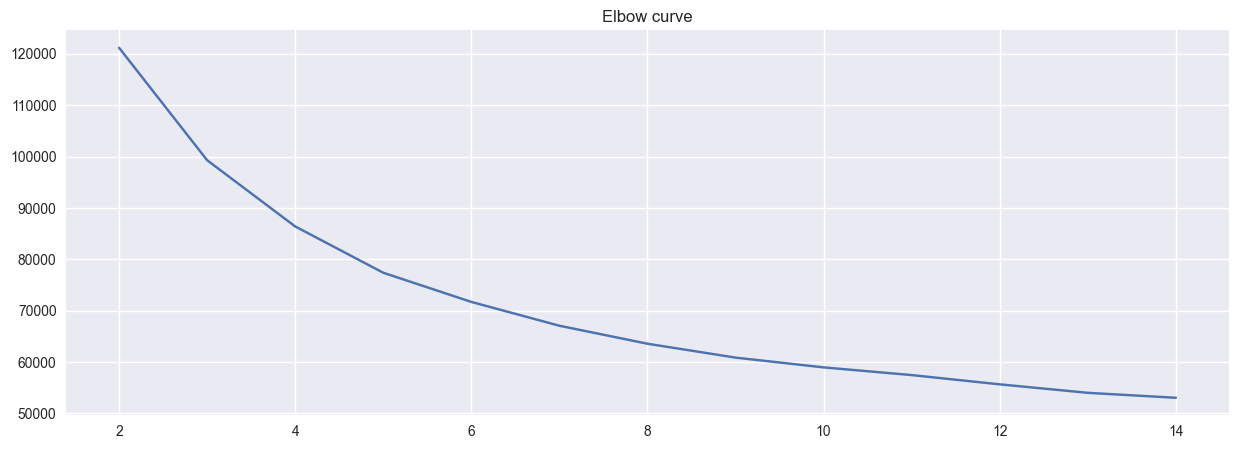

In [246]:
#Here we perform an elbow curve analysis to select a good number of cluster.
X = user_to_cat_first.values
distorsions = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [247]:
#From these analysis, we conclude that 4 or 5 clusters were a good number. There is a small elbow at 4, and the 
# silouette score of 4 and 5 are quite high. We will see what the clusters look like to make our final choice.

In [248]:
np.random.seed(10) #this is to ensure that we have consistency in the coloring/labels of the clustering!

user_clustering_5 = 0
user_clustering_4 = KMeans(4).fit(user_to_cat_first.values)
user_clustering_5 = KMeans(5).fit(user_to_cat_first.values)

In [249]:
count_4 = collections.Counter(user_clustering_4.labels_)
print('Number of users by cluster (k = 4)')
print(count_4)
count_5 = collections.Counter(user_clustering_5.labels_)
print('Number of users by cluster (k = 5)')
print(count_5)

Number of users by cluster (k = 4)
Counter({1: 394, 0: 239, 3: 196, 2: 141})
Number of users by cluster (k = 5)
Counter({2: 293, 4: 284, 3: 158, 0: 137, 1: 98})


In [250]:
#Prepare 4 clusters
df_cluster_beer_4 = pd.DataFrame(user_clustering_4.cluster_centers_.T)
df_cluster_beer_4.index = user_to_cat_first.columns
df_cluster_beer_4["category"] = df_cluster_beer_4.index
df_cluster_beer_4 = pd.melt(df_cluster_beer_4, id_vars=["category"], value_vars=[0,1,2,3])
df_cluster_beer_4.columns = ["category", "cluster", "Number of beer"]

In [251]:
#Prepare 5 clusters
df_cluster_beer_5 = pd.DataFrame(user_clustering_5.cluster_centers_.T)
df_cluster_beer_5.index = user_to_cat_first.columns
df_cluster_beer_5["category"] = df_cluster_beer_5.index
df_cluster_beer_5 = pd.melt(df_cluster_beer_5, id_vars=["category"], value_vars=[0,1,2,3,4])
df_cluster_beer_5.columns = ["category", "cluster", "Number of beer"]

In [252]:
#Display 4 clusters
fig = px.line(df_cluster_beer_4, x="category", y="Number of beer", color="cluster",
              title="Centroids obtained with Kmeans (k=4) of the first 50 ratings of each user")
fig.show()

In [253]:
#Display 5 clusters
fig = px.line(df_cluster_beer_5, x="category", y="Number of beer", color="cluster", 
              title="Centroids obtained with Kmeans (k=5) of the first 50 ratings of each user")
fig.show()


In [254]:
# We see that 3 clusters (blue, green and orange) are really correlated : they can be merged into 2,
# one whose users really likes IPA's and one whose users taste a lot of different beers.
# Therefore, we decide to work with 4 over 5 clusters.

In [255]:
# We settle on k = 4 
df_cluster_beer = df_cluster_beer_4.copy()
df_cluster_centers = pd.DataFrame(user_clustering_4.cluster_centers_.T)
df_cluster_centers.index = user_to_cat_first.columns

user_to_cat_first["first_50_cluster"] = user_clustering_4.labels_

In [256]:
df_cluster_centers

,0,1,2,3
category,,,,
Bocks,0.598326,1.659898,1.794326,0.816327
Brown Ales,1.732218,3.281726,2.723404,2.505102
Dark Ales,0.615063,1.654822,1.425532,0.959184
Dark Lagers,0.548117,1.530457,3.347518,0.632653
Hybrid Beers,0.234310,0.337563,0.382979,0.280612
India Pale Ales,22.832636,8.192893,3.297872,9.872449
Pale Ales,7.468619,9.408629,7.780142,4.750000
Pale Lagers,2.012552,3.868020,13.624113,1.295918
Porters,1.351464,2.296954,1.560284,3.096939


In [257]:
# We decide to give some names to the different clusters! The names are:
# Jean-Michel IPA, Marcel Stout, James Bland and Ada the explorer.

ipa_idx = (df_cluster_centers.loc['India Pale Ales',:]).argmax()
stout_idx = (df_cluster_centers.loc['Stouts',:]).argmax()
pale_idx = (df_cluster_centers.loc['Pale Lagers',:]).argmax()

possible_indices = [0,1,2,3] #column indices
expl_col = sum(possible_indices) - (ipa_idx + stout_idx + pale_idx)

mapping_name_idx = {'All' : 4, 'Jean-Michel IPA' : ipa_idx, 'Marcel Stout' : stout_idx, 

           'James Bland' : pale_idx, 'Ada the explorer' : expl_col}
mapping_idx_name = {values:key for key, values in mapping_name_idx.items()}
mapping_idx_name

{4: 'All',
 0: 'Jean-Michel IPA',
 3: 'Marcel Stout',
 2: 'James Bland',
 1: 'Ada the explorer'}

In [258]:
# Final clustering with names!
cl_names = df_cluster_beer['cluster'].apply(lambda cl_id : mapping_idx_name[cl_id])
fig = px.line(df_cluster_beer, x = "category", y = "Number of beer", color = cl_names, 
              title="Centroids obtained with Kmeans (k=4) of the first 50 ratings of each user")
fig.show()

# Comparison first 50 vs last 50 in the clusters

In [259]:
# How many beers of different categories a user rated in his last 50 ratings

df_ratings_last = df_valid_ratings[df_valid_ratings["rating_number"] >= 450]
user_to_cat_last = df_ratings_last.groupby(["user_name", "category"])["beer_id"].count()
user_to_cat_last = user_to_cat_last.unstack(level=-1, fill_value = 0)
user_to_cat_last.head(5)

category,Bocks,Brown Ales,Dark Ales,Dark Lagers,Hybrid Beers,India Pale Ales,Pale Ales,Pale Lagers,Porters,Specialty Beer,Stouts,Strong Ales,Weird Cocktail,Wheat Beers,Wild/Sour Beers
user_name,,,,,,,,,,,,,,,
-Rick,0,0,0,0,0,14,4,0,1,0,16,7,0,1,7
1000lbgrizzly,0,3,2,0,1,10,10,3,1,2,9,2,0,5,2
1424IpA,0,1,0,0,0,14,9,2,6,1,8,4,0,1,4
2Xmd,0,0,0,1,1,14,8,4,1,3,5,7,1,3,2
2ellas,0,3,1,2,0,15,3,10,3,1,6,3,0,2,1


In [260]:
#We keep track of each user assigned cluster (at the beginning and at the end)

user_to_cat_first["first_50_cluster"] = user_clustering_4.labels_
user_to_cat_last["first_50_cluster"] = user_clustering_4.labels_

user_to_cat_first.head(5)

category,Bocks,Brown Ales,Dark Ales,Dark Lagers,Hybrid Beers,India Pale Ales,Pale Ales,Pale Lagers,Porters,Specialty Beer,Stouts,Strong Ales,Weird Cocktail,Wheat Beers,Wild/Sour Beers,first_50_cluster
user_name,,,,,,,,,,,,,,,,
-Rick,0,2,0,2,0,29,7,2,2,2,3,1,0,0,0,0
1000lbgrizzly,0,5,0,1,0,4,9,7,2,8,6,4,0,3,1,1
1424IpA,0,0,1,0,0,21,3,1,1,1,12,4,0,1,5,0
2Xmd,0,2,1,1,0,25,5,1,1,2,9,1,0,2,0,0
2ellas,0,2,1,0,0,31,9,0,0,0,2,4,0,1,0,0


In [261]:
## To be even more confident about our clusters, we bootstrap the data to get 95% confidence intervals.

cluster_list=[]
cate_list=[]
ci_low_mean_first_rating_list=[]
ci_high_mean_first_rating_list=[]
mean_first_rating_list=[]
ci_low_mean_last_rating_list=[]
ci_high_mean_last_rating_list=[]
mean_last_rating_list=[]
t_test_list=[]

cluster_team = user_to_cat_first['first_50_cluster'].unique()
categ_beer = user_to_cat_first.columns[0:15]

for team in cluster_team:

    current_team_first_rating = user_to_cat_first[user_to_cat_first['first_50_cluster']==team]
    current_team_last_rating = user_to_cat_last[user_to_cat_last['first_50_cluster']==team]

    for cate in categ_beer:

        current_ttest=ttest_rel(current_team_first_rating[cate],current_team_last_rating[cate])[1]
        #if current_ttest<0.05:
            #print('the p-value for ttest in the team',team,'for the category',cate,'is',current_ttest)

        ci_low_mean_first_rating, ci_high_mean_first_rating = bootstrap((current_team_first_rating[cate].values,), np.mean).confidence_interval
        ci_low_mean_last_rating, ci_high_mean_last_rating = bootstrap((current_team_last_rating[cate].values,), np.mean).confidence_interval

        mean_first_rating_list.append(current_team_first_rating[cate].mean())
        mean_last_rating_list.append(current_team_last_rating[cate].mean())

        cluster_list.append(team)
        cate_list.append(cate)

        ci_low_mean_first_rating_list.append(ci_low_mean_first_rating)
        ci_high_mean_first_rating_list.append(ci_high_mean_first_rating)
        ci_low_mean_last_rating_list.append(ci_low_mean_last_rating)
        ci_high_mean_last_rating_list.append(ci_high_mean_last_rating)
        t_test_list.append(current_ttest)

In [262]:
conf_inter_cluster = pd.DataFrame({'Cluster' : cluster_list, 'Category' : cate_list, 'CI_low_first_rating':ci_low_mean_first_rating_list,
                                'CI_high_first_rating':ci_high_mean_first_rating_list,'mean_first_ratings':mean_first_rating_list,
                                'CI_low_last_rating':ci_low_mean_last_rating_list,'CI_high_last_rating':ci_high_mean_last_rating_list,
                                'mean_last_ratings':mean_last_rating_list,'t_test':t_test_list})

In [263]:
## We also perform bootstrapping on all users (without clustering)

cate_list=[]
ci_low_mean_first_rating_list=[]
ci_high_mean_first_rating_list=[]
mean_first_rating_list=[]
ci_low_mean_last_rating_list=[]
ci_high_mean_last_rating_list=[]
mean_last_rating_list=[]
t_test_list=[]
categ_beer = user_to_cat_first.columns[0:15]

for cate in categ_beer:

    current_ttest=ttest_rel(user_to_cat_first[cate],user_to_cat_last[cate])[1]
    #if current_ttest<0.05:
    #print('the p-value for ttest in the team',team,'for the category',cate,'is',current_ttest)
    ci_low_mean_first_rating, ci_high_mean_first_rating = bootstrap(
        (user_to_cat_first[cate].values,), np.mean
    ).confidence_interval
    ci_low_mean_last_rating, ci_high_mean_last_rating = bootstrap(
        (user_to_cat_last[cate].values,), np.mean
    ).confidence_interval
    mean_first_rating_list.append(user_to_cat_first[cate].mean())
    mean_last_rating_list.append(user_to_cat_last[cate].mean())
    cate_list.append(cate)
    ci_low_mean_first_rating_list.append(ci_low_mean_first_rating)
    ci_high_mean_first_rating_list.append(ci_high_mean_first_rating)
    ci_low_mean_last_rating_list.append(ci_low_mean_last_rating)
    ci_high_mean_last_rating_list.append(ci_high_mean_last_rating)
    t_test_list.append(current_ttest)

In [264]:
conf_inter_all= pd.DataFrame({ 'Category' : cate_list, 'CI_low_first_rating':ci_low_mean_first_rating_list,
                    'CI_high_first_rating':ci_high_mean_first_rating_list,'mean_first_ratings':mean_first_rating_list,
                    'CI_low_last_rating':ci_low_mean_last_rating_list,'CI_high_last_rating':ci_high_mean_last_rating_list,
                    'mean_last_ratings':mean_last_rating_list,'t_test':t_test_list})
conf_inter_all['Cluster'] = 'All'
conf_inter_all.head(5)

,Category,CI_low_first_rating,CI_high_first_rating,mean_first_ratings,CI_low_last_rating,CI_high_last_rating,mean_last_ratings,t_test,Cluster
0,Bocks,1.158763,1.339175,1.247423,0.854639,1.020619,0.932990,1.040049e-08,All
1,Brown Ales,2.534021,2.791753,2.661856,1.974227,2.192784,2.082474,9.232355e-14,All
2,Dark Ales,1.135086,1.314433,1.224742,0.761856,0.913402,0.837113,5.993624e-13,All
3,Dark Lagers,1.271134,1.475258,1.371134,0.722680,0.860825,0.790722,8.970276e-25,All
4,Hybrid Beers,0.272165,0.342268,0.307216,0.277320,0.348454,0.312371,8.332273e-01,All


In [265]:
df_conf_inter = pd.concat([conf_inter_all, conf_inter_cluster], ignore_index = True)
df_conf_inter.head(5)

,Category,CI_low_first_rating,CI_high_first_rating,mean_first_ratings,CI_low_last_rating,CI_high_last_rating,mean_last_ratings,t_test,Cluster
0,Bocks,1.158763,1.339175,1.247423,0.854639,1.020619,0.932990,1.040049e-08,All
1,Brown Ales,2.534021,2.791753,2.661856,1.974227,2.192784,2.082474,9.232355e-14,All
2,Dark Ales,1.135086,1.314433,1.224742,0.761856,0.913402,0.837113,5.993624e-13,All
3,Dark Lagers,1.271134,1.475258,1.371134,0.722680,0.860825,0.790722,8.970276e-25,All
4,Hybrid Beers,0.272165,0.342268,0.307216,0.277320,0.348454,0.312371,8.332273e-01,All


In [266]:
df_pivot = df_conf_inter.pivot(index='Category', columns='Cluster')
df_pivot.columns = df_pivot.columns.to_flat_index()
df_pivot.head(5)

,"(CI_low_first_rating, 0)","(CI_low_first_rating, 1)","(CI_low_first_rating, 2)","(CI_low_first_rating, 3)","(CI_low_first_rating, All)","(CI_high_first_rating, 0)","(CI_high_first_rating, 1)","(CI_high_first_rating, 2)","(CI_high_first_rating, 3)","(CI_high_first_rating, All)",...,"(mean_last_ratings, 0)","(mean_last_ratings, 1)","(mean_last_ratings, 2)","(mean_last_ratings, 3)","(mean_last_ratings, All)","(t_test, 0)","(t_test, 1)","(t_test, 2)","(t_test, 3)","(t_test, All)"
Category,,,,,,,,,,,,,,,,,,,,,
Bocks,0.493724,1.517766,1.539007,0.673469,1.158763,0.715481,1.817259,2.092199,0.969388,1.339175,...,0.531381,1.116751,1.631206,0.551020,0.932990,0.378103,1.210879e-08,4.189340e-01,0.002002,1.040049e-08
Brown Ales,1.543933,3.076142,2.397163,2.224490,2.534021,1.925201,3.489848,3.070922,2.795918,2.791753,...,1.263598,2.489848,2.617021,1.877551,2.082474,0.000191,1.567179e-09,6.209248e-01,0.000374,9.232355e-14
Dark Ales,0.510460,1.505076,1.198582,0.794748,1.135086,0.736402,1.812183,1.680851,1.139349,1.314433,...,0.451883,1.050761,1.219858,0.602041,0.837113,0.023793,3.901109e-10,2.220434e-01,0.000568,5.993624e-13
Dark Lagers,0.447699,1.388325,3.035461,0.505102,1.271134,0.669456,1.672589,3.666667,0.780612,1.475258,...,0.489540,0.923858,1.269504,0.545918,0.790722,0.424669,4.049361e-12,1.775291e-21,0.346989,8.970276e-25
Hybrid Beers,0.171548,0.281726,0.276596,0.209184,0.272165,0.301255,0.393401,0.492549,0.357143,0.342268,...,0.246862,0.390863,0.297872,0.244898,0.312371,0.790709,1.923013e-01,2.219053e-01,0.438106,8.332273e-01


In [267]:
df_means = df_pivot.iloc[:,10:15]

In [268]:
# Interactive plot with the different clusters for Kmeans with k = 4
mean_user = df_pivot.copy()

# plotly setup 
fig = go.Figure()

# Add all the traces
x = mean_user.index

for key in mapping_name_idx.keys():
    viz = False
    if key == "All":
        viz = True
    
    #last
    #mean
    fig.add_trace(go.Scatter(x=x, y=mean_user.iloc[:, 25 + mapping_name_idx[key]].values,
                             name='last 50 beers', mode='lines', line_color='rgb(239,85,59)', 
                             visible=viz, showlegend=True))
    #CI low
    fig.add_trace(go.Scatter(x=x, y=mean_user.iloc[:, 15 + mapping_name_idx[key]].values,
                             name='first, CI Low', fill=None, mode='lines', line_width = 0.00,
                             fillcolor='rgba(239,85,59,0.3)', visible=viz, showlegend=False))
    #CI high
    fig.add_trace(go.Scatter(x=x, y=mean_user.iloc[:, 20 + mapping_name_idx[key]].values,
                             name='first, CI high', fill='tonexty', mode='lines', line_width = 0.00,
                             fillcolor='rgba(239,85,59,0.3)', visible=viz, showlegend=False))

    #first
    #mean
    fig.add_trace(go.Scatter(x=x, y=mean_user.iloc[:, 10 + mapping_name_idx[key]].values,
                             name='first 50 beers', mode='lines', line_color = "rgb(0,204,150)",
                             visible=viz, showlegend=True))
    #CI low
    fig.add_trace(go.Scatter(x=x, y=mean_user.iloc[:, 0 + mapping_name_idx[key]].values,
                             name='first, CI Low', fill=None, mode='lines', line_width = 0.00,
                             fillcolor='rgba(0,204,150,0.3)', visible=viz, showlegend=False))
    #CI high
    fig.add_trace(go.Scatter(x=x, y=mean_user.iloc[:, 5 + mapping_name_idx[key]].values,
                             name='first, CI High', fill='tonexty', mode='lines', line_width = 0.00,
                             fillcolor='rgba(0,204,150,0.3)', visible=viz, showlegend=False))

#build 5 mask coresponding to each button
list_0 = [True]*6 + [False]*24
list_1 = [False]*6 + [True]*6 + [False]*18
list_2 = [False]*12 + [True]*6 + [False]*12
list_3 = [False]*18 + [True]*6 + [False]*6
list_4 = [False]*24 + [True]*6

fig.update_layout(
    yaxis_range=[0,25],
    width=1000,
    height=600,
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1,
            y=1.1,
            buttons=list([
                dict(label="All togheter",
                     method="update",
                     args=[{"visible": list_0},
                           {'title':'All together : average number of beers rated from each category'}]),
                dict(label="Jean-Michel IPA",
                     method="update",
                     args=[{"visible": list_1},
                           {'title' : 'Team "Jean-Michel IPA" : average number of beers rated from each category'}]),
                dict(label="Marcel Stout",
                     method="update",
                     args=[{"visible": list_2},
                           {'title' : 'Team "Marcel Stout" : average number of beers rated from each category'}]),
                dict(label="James Bland",
                     method="update",
                     args=[{"visible": list_3},
                           {'title' : 'Team "James Bland" : average number of beers rated from each category'}]),
                dict(label="Ada the explorer",
                     method="update",
                     args=[{"visible": list_4},
                           {'title' : 'Team "Ada the explorer" : average number of beers rated from each category'}])

            ]),
        )
    ])

# Set title
fig.update_xaxes(title_text="Category")
fig.update_yaxes(title_text="Number of beers")

fig.update_layout({'title' : 'All together : average number of beers rated from each category'})

fig.show()
#fig.write_html("all_first_vs_last.html")

In [269]:
#Heatmap to show the confidence in the changes

df_pval = mean_user.iloc[:,30:35].T.copy()
pval = df_pval.to_numpy()
#print(pval.dtypes)

idx = {k: v for k, v in sorted(mapping_name_idx.items(), key=lambda item: item[1])}


#We clip extreme values for visibility 
pval[pval < 1e-20] = 1e-20 #extremelly confident
pval[pval > 0.05] = 1      #unsignificant
pval = -np.log10(pval)
pval = np.round(pval,2)

fig = px.imshow(pval, text_auto=True,
                title="Confidence in the change of the number of beers rated in each category <br>"\
                      "between the first 50 and last 50 ratings per cluster<br><sup>"\
                      "Heatmap of -log10(pval) (with pval > 0.05 clipped to 1 and pval < 1e-20 clipped to 1e-20)</sup>",
                labels=dict(x="Category", y="Clusters", color="-log10(Pvalue)"),
                x=df_pval.columns.values,
                y=list(idx.keys()),
               )

fig.update_layout(coloraxis_colorbar=dict(
    title="-log(Pvalue)",
    tickvals=[1,5,10,20],
    ticktext=["1", "5", "10", "20"],
))


fig.show()

# Dimensionality reduction

In [270]:
# To vizualize our clusters, we procede a dimensionality reduction with PCA and UMAP

### PCA

In [271]:
#plot by using pca methods in order to have a visualization of our clustering

pca_3 = PCA(n_components=3)
users_pca_3 = pca_3.fit_transform(user_to_cat_first[user_to_cat_first.columns[0:15]].values)
print('the variances explained by the 3 first principal components are',pca_3.explained_variance_ratio_,'(respectively)')

# We store the results in a dataframe - indices keep the same order
users_pca_3 = pd.DataFrame(users_pca_3)
users_pca_3.index = user_to_cat_first.index
users_pca_3.columns= ['Principal component 1','Principal component 2','Principal component 3']
users_pca_3['cluster'] = user_to_cat_first['first_50_cluster']

the variances explained by the 3 first principal components are [0.43681178 0.23533086 0.10548838] (respectively)


In [272]:
users_pca_3.sort_values(by = 'cluster', inplace=True) #to guarantee color consistency
cl_names = users_pca_3['cluster'].apply(lambda cl : mapping_idx_name[cl])
fig = px.scatter_3d(users_pca_3, x='Principal component 1', y='Principal component 2', z='Principal component 3',opacity =1,
             color=cl_names ,size_max =50,width=1000, height=600,title ='PCA projection of the 15 categories into the 3 Principal components')

fig.show()

In [273]:
pca_2 = PCA(n_components=2)
users_pca_2 = pca_2.fit_transform(user_to_cat_first[user_to_cat_first.columns[0:15]].values)
print('the variances explained by the 2 first principal components are',pca_2.explained_variance_ratio_,'(respectively)')

the variances explained by the 2 first principal components are [0.43681178 0.23533086] (respectively)


In [274]:
users_pca_2 = pd.DataFrame(users_pca_2)
users_pca_2.index = user_to_cat_first.index
users_pca_2.columns=['Principal component 1','Principal component 2']
users_pca_2['cluster'] = user_to_cat_first['first_50_cluster']

In [275]:
#Plot of PCA
users_pca_2.sort_values(by = 'cluster', inplace=True) #to guarantee color consistency
cl_names = users_pca_2['cluster'].apply(lambda cl: mapping_idx_name[cl])
fig = px.scatter(users_pca_2, x='Principal component 1', y='Principal component 2',opacity =1,
             color = cl_names ,size_max =50,width=1000, height=600,title ='PCA projection of the 15 categories into the 2 Principal components',
             range_x = [-20,25], range_y=[-20,40])
fig.show()
#fig.write_html("cluster_2dvisual.html")

### UMAP

In [70]:
# We also want to visualize our clustering with a non-linear projection techniques. 
# Therefore, we use a non linear dimension reduction technique called UMAP.

trans = UMAP(n_neighbors=70, random_state=852484677).fit(user_to_cat_first[user_to_cat_first.columns[0:15]].values)

user_projected_umap=pd.DataFrame(trans.embedding_)
user_projected_umap.columns = ['Axis x','Axis y']
user_projected_umap.index = user_to_cat_first.index
user_projected_umap['cluster'] = user_to_cat_first['first_50_cluster']

In [71]:
#Plot of UMAP

user_projected_umap.sort_values(by = 'cluster', inplace=True) #to guarantee color consistency
cl_names = user_projected_umap['cluster'].apply(lambda cl: mapping_idx_name[cl])

fig = px.scatter(user_projected_umap, x='Axis x', y='Axis y',opacity =1,
             color = cl_names ,size_max =50,width=1000, height=600,title = 'UMAP of the 15 categories', range_x=[0,12], range_y =[1,7])

fig.show()
#fig.write_html("cluster_visual_umap.html")

#### Display

In [72]:
### on same plot with buttons
list_0 = [True]*4 + [False]*4
list_1 = [False]*4 + [True]*4
list_2 = [True]*8

fig = go.Figure()

for cluster_id in [0,1,2,3]:
    fig.add_trace(go.Scatter(x=users_pca_2.loc[users_pca_2['cluster'] == cluster_id]['Principal component 1'], y=users_pca_2.loc[users_pca_2['cluster']==cluster_id]['Principal component 2'], mode='markers', visible=True, name=mapping_idx_name[cluster_id]))

for cluster_id in [0,1,2,3]:
    fig.add_trace(go.Scatter(x=user_projected_umap.loc[user_projected_umap['cluster'] == cluster_id]['Axis x'], y=user_projected_umap.loc[user_projected_umap['cluster']==cluster_id]['Axis y'], mode='markers', visible=False, name=mapping_idx_name[cluster_id]))

fig.update_layout(
    width=1000,
    height=600,
    updatemenus=[
        dict(
            type="buttons",
            direction="right",

            active=0,
            x=1,
            y=1.1,
            buttons=list([
                dict(label="PCA",
                     method="update",
                     args=[{"visible": list_0}]),
                dict(label="UMAP",
                
                     method="update",
                     args=[{"visible": list_1}]),
            ]),
        )
    ])

#TODO??
#fig.update_layout(yaxis_range=[-4,4])
#fig.update_layout(xaxis_range=[-5,5])

# Set title
fig.update_xaxes(title_text="axis 1")
fig.update_yaxes(title_text="axis 2")
fig.update_layout(
    title_text="PCA and UMAP projections",
)

fig.show()
#fig.write_html("umap_pca.html")